# Revisão de código 

Olá! 

Meu nome é Suelen. Estou feliz em revisar seu projeto hoje!

Quando vejo um erro pela primeira vez, apenas aponto. Deixarei você encontrá-lo e corrigi-lo sozinho. Além disso, ao longo do texto, farei algumas observações sobre melhorias no código e também farei comentários sobre suas percepções sobre o assunto. Mas se você ainda não consegue lidar com essa tarefa, darei uma dica mais precisa na próxima iteração e também alguns exemplos práticos. Estarei aberto a feedbacks e discussões sobre o tema.

Você pode encontrar meus comentários em caixas verdes, amarelas ou vermelhas como estas:


<div class="alert alert-block alert-success">
<b>Comentário: </b> <a class="tocSkip"></a>

Sucesso. Tudo está correto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário: </b> <a class="tocSkip"></a>

Observações. Algumas recomendações.
</div>

<div class="alert alert-block alert-danger">

<b>Comentário: </b> <a class="tocSkip"></a>

O bloco requer algumas correções. O trabalho não pode ser aceito com os comentários vermelhos.
</div>

Você pode me responder usando isto:

<div class="alert alert-block alert-info">
<b>Resposta do aluno</b> <a class="tocSkip"></a>
</div>



<div class="alert alert-block alert-success">
<b>Comentário geral: </b> <a class="tocSkip"></a>

Parabéns pela conclusão do projeto, Gabriel! Seu trabalho ficou muito bom: o código está bem organizado, as análises fazem sentido e mostram que você entendeu bem os conceitos.

Foi ótimo ver a forma como você aplicou o que aprendeu nas lições. Seu progresso é nítido!

Projeto aprovado, continue nesse ritmo!

# Projeto de Conclusão de Curso - Data Science - Tripleten

- Aluno: Gabriel Chaves Veras
- Turma: DS25

# Solução

In [90]:
# Importando bibliotecas úteis nesta etapa:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [91]:
# Carregando dados e transformando em dataframe Pandas:
data_arc = pd.read_csv('data_arc_en.csv')
data_bulk = pd.read_csv('data_bulk_en.csv')
data_bulk_time = pd.read_csv('data_bulk_time_en.csv')
data_gas = pd.read_csv('data_gas_en.csv')
data_temp = pd.read_csv('data_temp_en.csv')
data_wire = pd.read_csv('data_wire_en.csv')
data_wire_tim = pd.read_csv('data_wire_time_en.csv')

In [92]:
# Copiando etapas iniciais de tratamento do modelo conforme etapa anterior:
data_arc['Arc heating start'] = pd.to_datetime(data_arc['Arc heating start'])
data_arc['Arc heating end'] = pd.to_datetime(data_arc['Arc heating end'])
df_data_temp = data_temp.dropna(subset=['Temperature']).copy() #Inserido .copy para evitar a mensagem de atenção
df_data_temp['Sampling time'] = pd.to_datetime(df_data_temp['Sampling time'])

- #### Trabalhando o DF data_arc:

O dataframe mostra os momentos de aquecimento de determinado lote, com dados de potência ativa e reativa. Cada lote pode possuir mais de um momento em que é aquecido, portanto "pacotes" de energia são inseridos ao lote, que ao final correspondem ao total de energia gasto. Vamos calcular este gasto energético conforme a equação:

$$Q_{efetivo} = P_{ativa} \times ({t_{end} - t_{start}}) $$

Para possibilitar nossa análise preditiva, precisamos definir como utilizar os valores contidos em df_data_arc na análise. Foram escolhidas quatro estatísticas no momento: média, máximo, mínimo e soma. Criamos um novo dataframe com estes dados para posteriormente unirmos tudo em um dataframe completo.

In [93]:
# Calcular a duração (em segundos)
df_data_arc = data_arc.copy()
df_data_arc['duration'] = (df_data_arc['Arc heating end'] - df_data_arc['Arc heating start']).dt.total_seconds()

# Calcular Energia Ativa Total (sem unidade)
df_data_arc['energy_total'] = df_data_arc['Active power'] * df_data_arc['duration']


In [94]:
# Agora é necessário transformar os diversos valores por lote em estatísticas unívocas. Criaremos o DF power_stats para compilar as novas informações:

# Coluna Active power:
# A coluna refere-se a valores brutos de potência ativa, que não possuem significado físico se somadas. Portanto, vamos utilizar apenas os valores máximo e mínimo observados:
Apower_stats = df_data_arc.groupby('key')['Active power'].agg(['max', 'min']).reset_index()
Apower_stats.columns = ['key', 'max_act_power', 'min_act_power']

# Coluna Reactive power:
# A coluna refere-se a valores brutos de potência reativa, que não possuem significado físico se somadas. Portanto, vamos utilizar apenas os valores máximo e mínimo observados:
Rpower_stats = df_data_arc.groupby('key')['Reactive power'].agg(['max', 'min']).reset_index()
Rpower_stats.columns = ['key', 'max_react_power', 'min_react_power']

# Coluna duration:
# A coluna refere-se a duração do aquecimento em cada momento. Vamos utilizar valores de máximo, mínimo, soma total e média para esta coluna:
duration = df_data_arc.groupby('key')['duration'].agg(['mean', 'max', 'min', 'sum']).reset_index()
duration.columns = ['key', 'mean_dur', 'max_dur', 'min_dur', 'sum_dur']

# Coluna energy_total:
# A coluna refere-se a energia consumida durante o aquecimento em cada momento. Vamos utilizar valores de máximo, mínimo, soma total e média para esta coluna:
energy_total = df_data_arc.groupby('key')['energy_total'].agg(['mean', 'max', 'min', 'sum']).reset_index()
energy_total.columns = ['key', 'mean_energy', 'max_energy', 'min_energy', 'sum_energy']

In [95]:
# Agora iremons unir todas as informações num mesmo DF:

power_stats = pd.merge(Apower_stats, Rpower_stats, on='key')
power_stats = pd.merge(power_stats, duration, on='key')
power_stats = pd.merge(power_stats, energy_total, on='key')

# Identificamos um valor negativo para Reactive Power que estava prejudicando o comportamento da variável (verificado nos gráficos abaixo). 
# Visto que não há valor físico que explique potências negativas para o sistema em estudo, vamos realizar o tratamento para todo o DF::
for col in power_stats.columns:
    power_stats[col] = power_stats[col].apply(lambda x: np.nan if x < 0 else x)

- #### Trabalhando o DF data_bulk:

Não há o que tratar no DF data_bulk. Os valores já estão unívocos por 'key' e bem separados por coluna.

- #### Trabalhando o DF data_bulk_time:

Como não havíamos ajustado os tipos de dados para o DF data_bulk_time, faremos isso agora. Identificamos a necessidade de criação de uma função simples para tornar o código mais limpo.

In [96]:
# Função para transformar colunas em valores .datetime de forma massiva:
def transform_date(df, column):
    df[column] = pd.to_datetime(df[column])

# Aplicando a função no DF:
for column in data_bulk_time.columns[1:]:
    transform_date(data_bulk_time, column)


- #### Trabalhando o DF data_gas:

Não há o que tratar no DF data_gas. Os valores já estão unívocos por 'key' e no tipo adequado.

- #### Trabalhando o DF df_data_temp:

df_data_temp contém dados de medição de temperatura ao longo do processo produtivo. Cada 'key' pode possuir diversos valores, portanto precisamos definir como utilizar estes valores na análise. Foram escolhidas quatro estatísticas no momento: média, máximo, mínimo e última. Criamos um novo dataframe com estes dados para posteriormente unirmos tudo em um dataframe completo.

In [97]:
temp_stats = df_data_temp.groupby('key')['Temperature'].agg(['mean', 'max', 'min', 'last']).reset_index()
temp_stats.columns = ['key', 'mean_temp', 'max_temp', 'min_temp', 'last_temp']

- #### Trabalhando o DF data_wire:

Não há o que tratar no DF data_wire. Os valores já estão unívocos por 'key' e bem separados por coluna.

- #### Trabalhando o DF data_wire_tim:

Como não havíamos ajustado os tipos de dados para o DF data_wire_tim, faremos isso agora, aplicando a função criada anteriormente.

In [98]:
for column in data_wire_tim.columns[1:]:
    transform_date(data_wire_tim, column)


In [99]:
def extract_datetime_features(df, datetime_col):
    df[f'{datetime_col}_year'] = df[datetime_col].dt.year
    df[f'{datetime_col}_month'] = df[datetime_col].dt.month
    df[f'{datetime_col}_day'] = df[datetime_col].dt.day
    df[f'{datetime_col}_hour'] = df[datetime_col].dt.hour
    return df

- #### Unindo dataframes

Relação dos DFs para união:

power_stats

data_bulk

data_bulk_time

data_gas

temp_stats

data_wire

data_wire_tim

In [100]:
df_analysis = pd.merge(power_stats, data_bulk, on='key', how='outer')
df_analysis = pd.merge(df_analysis, data_bulk_time, on='key', how='outer')
df_analysis = pd.merge(df_analysis, data_gas, on='key', how='outer')
df_analysis = pd.merge(df_analysis, temp_stats, on='key', how='outer')
df_analysis = pd.merge(df_analysis, data_wire, on='key', how='outer')
df_analysis = pd.merge(df_analysis, data_wire_tim, on='key', how='outer')

In [101]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              3241 non-null   int64         
 1   max_act_power    3214 non-null   float64       
 2   min_act_power    3214 non-null   float64       
 3   max_react_power  3214 non-null   float64       
 4   min_react_power  3213 non-null   float64       
 5   mean_dur         3214 non-null   float64       
 6   max_dur          3214 non-null   float64       
 7   min_dur          3214 non-null   float64       
 8   sum_dur          3214 non-null   float64       
 9   mean_energy      3214 non-null   float64       
 10  max_energy       3214 non-null   float64       
 11  min_energy       3214 non-null   float64       
 12  sum_energy       3214 non-null   float64       
 13  Bulk 1_x         252 non-null    float64       
 14  Bulk 2_x         22 non-null     float64

- #### Análise visual das principais colunas numéricas

Agora que já temos todos os dados unidos num único dataframe, que será utilizado em nosso modelo, precisamos entender o comportamento das variáveis para saber qual scaler se adequa melhor ao dataset. Vamos plotar boxplots e histogramas para as variáveis estatísticas criadas a partir dos valores de potência e temperatura originais.

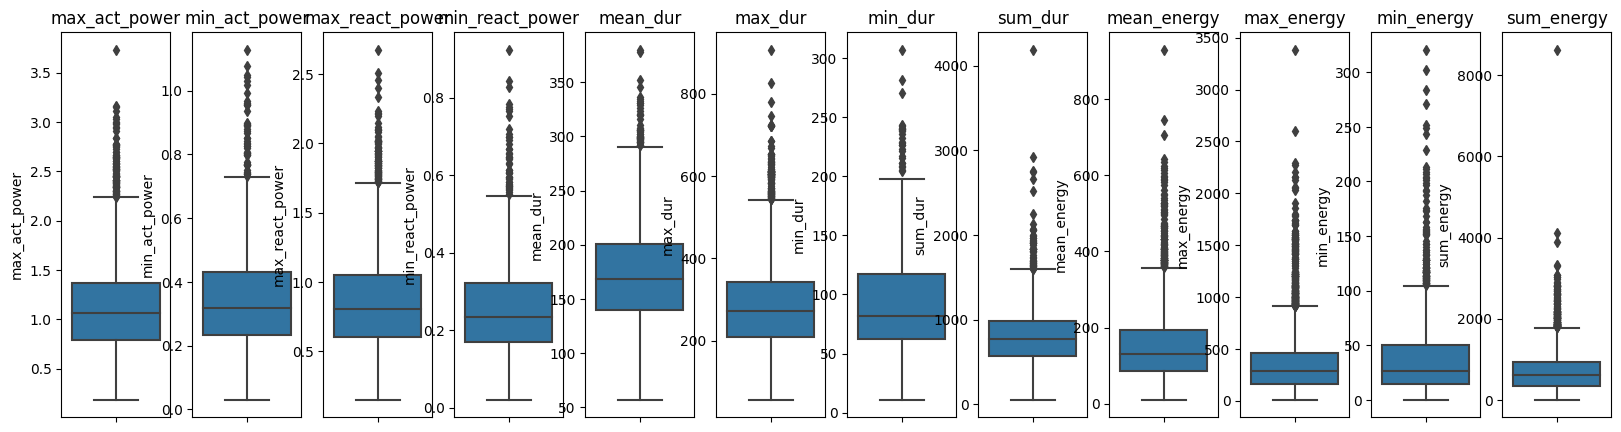

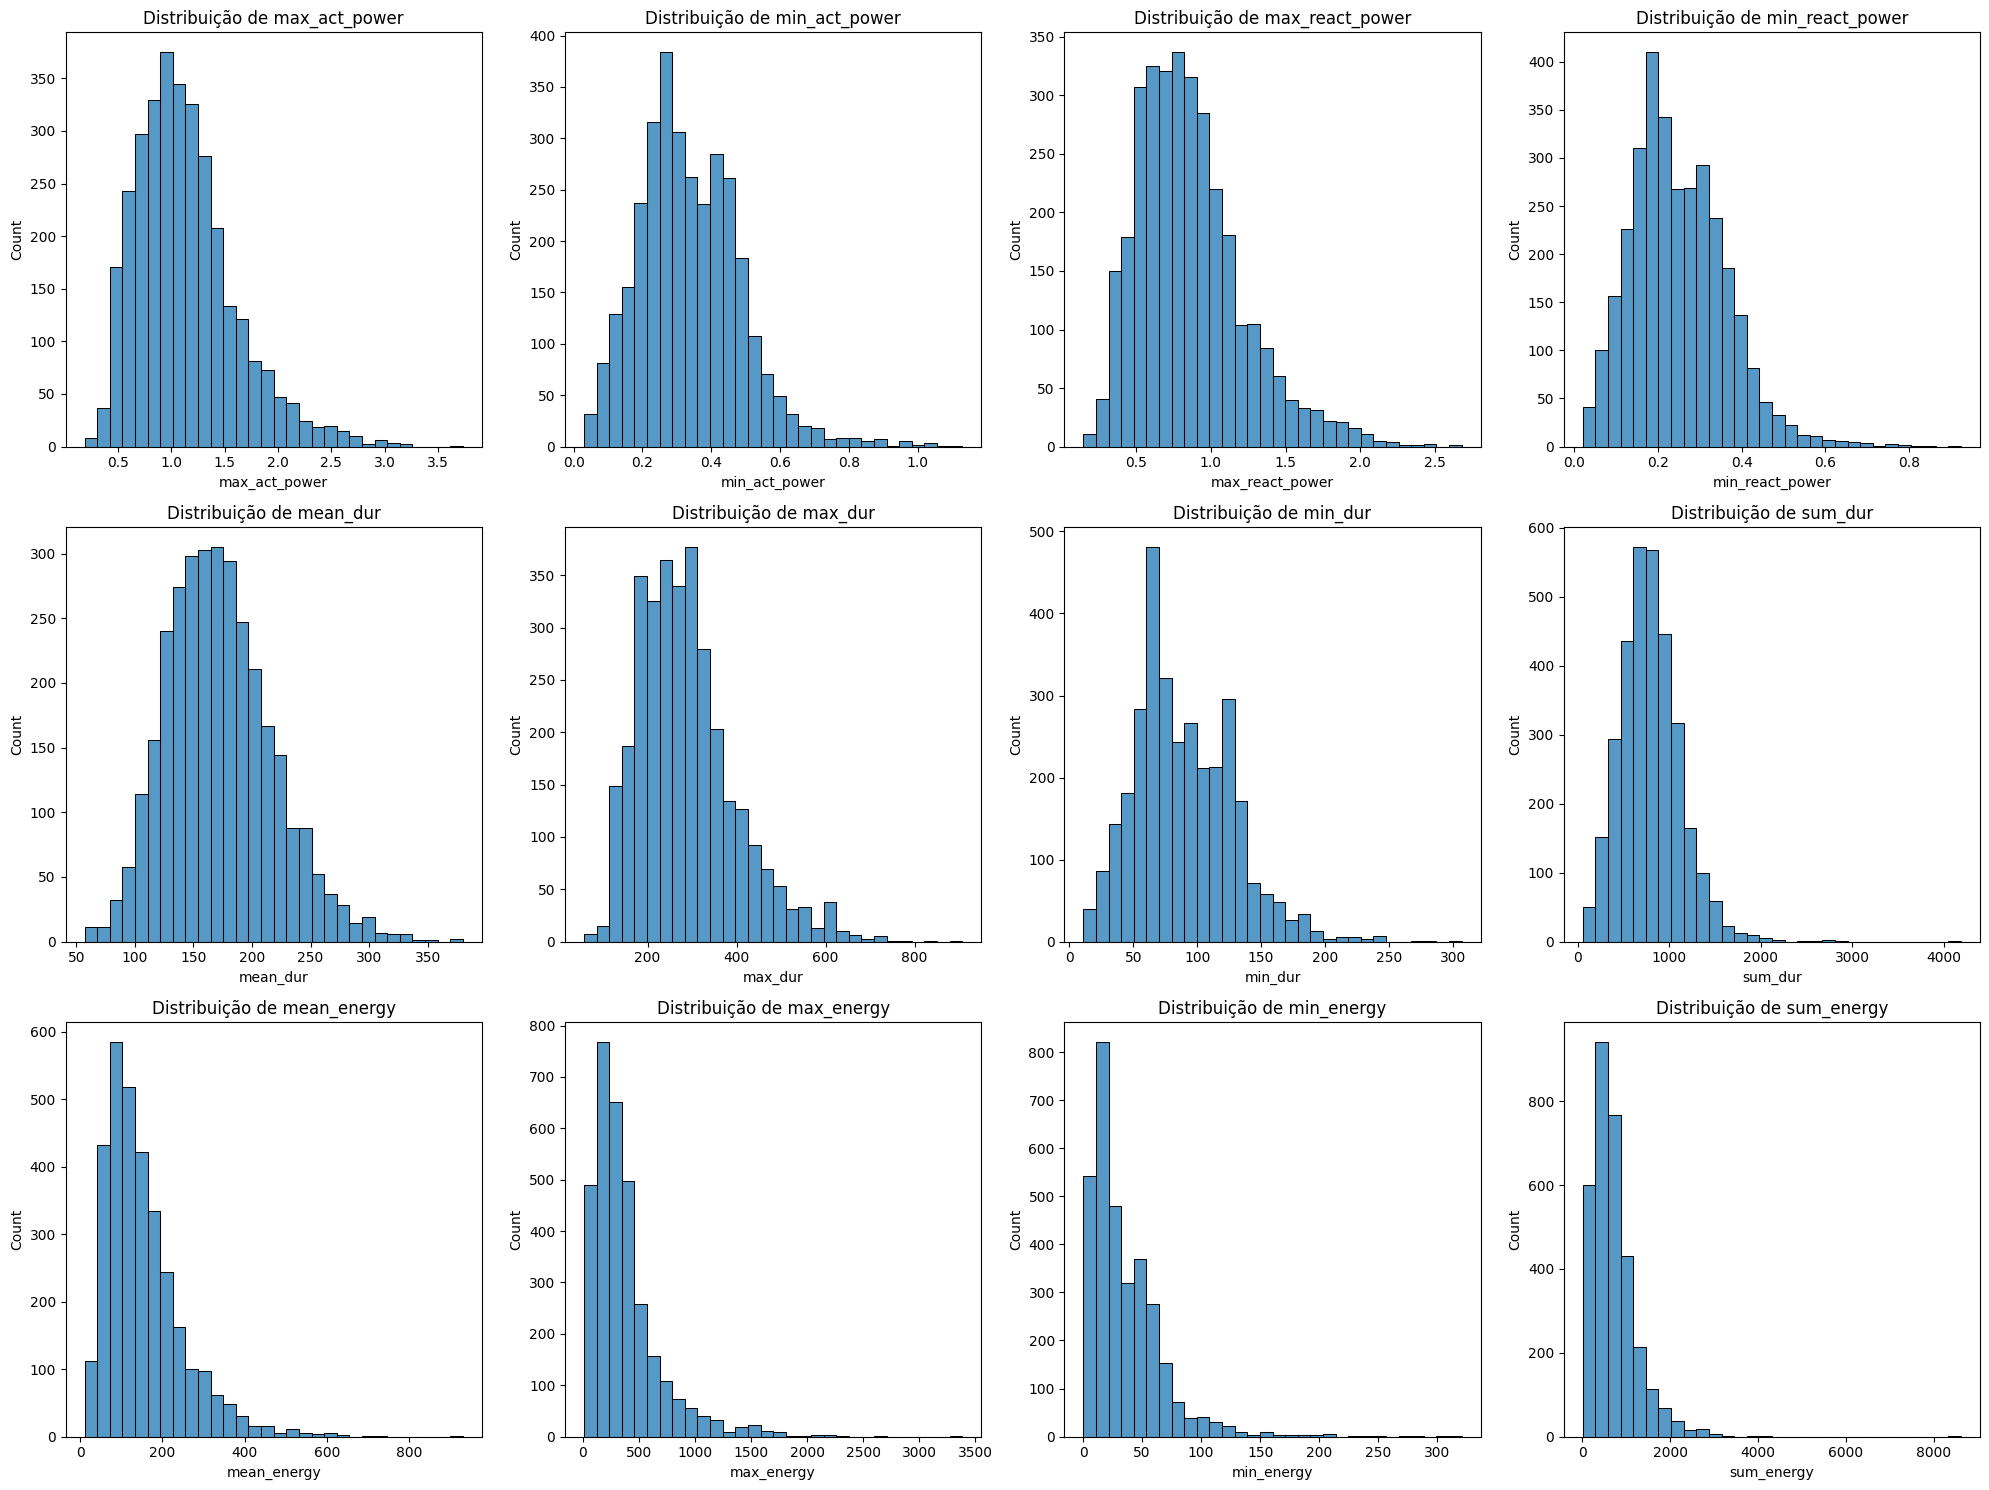

In [102]:
# Avaliando variáveis com boxplots e histogramas para os dados de potência:
main_vars = df_analysis.columns[1:13]

# Criando boxplots
fig, axes = plt.subplots(1, len(main_vars), figsize=(20, 5))
for i, var in enumerate(main_vars):
    sns.boxplot(y=df_analysis[var], ax=axes[i])
    axes[i].set_title(var)

# Criando histogramas
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, var in enumerate(main_vars):
    sns.histplot(data=df_analysis, x=var, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribuição de {var}')
    
plt.tight_layout()
plt.show()

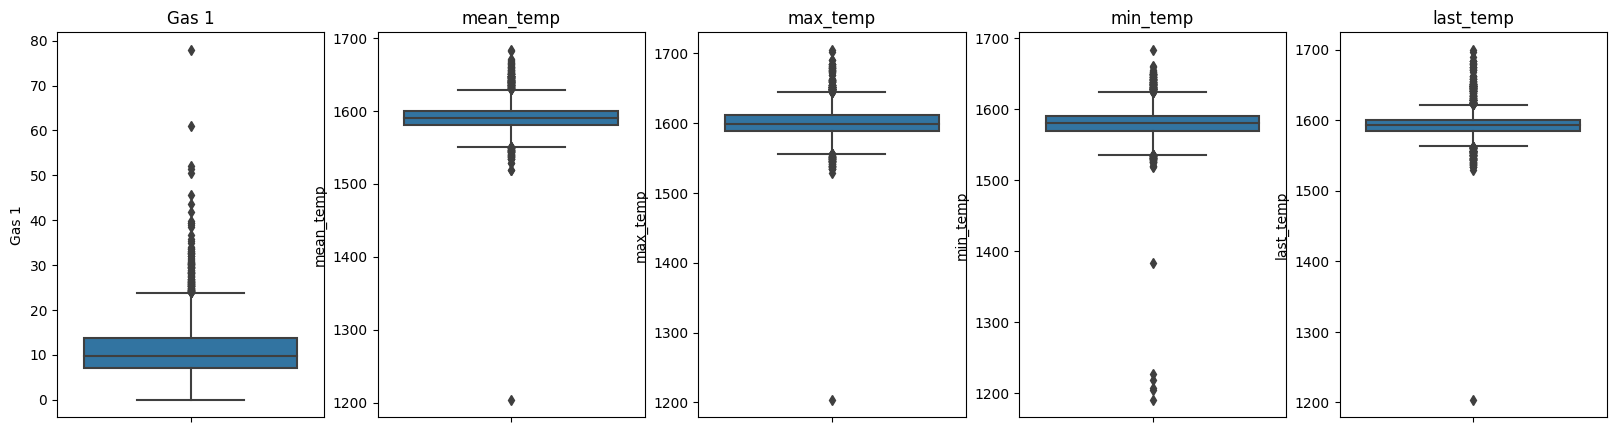

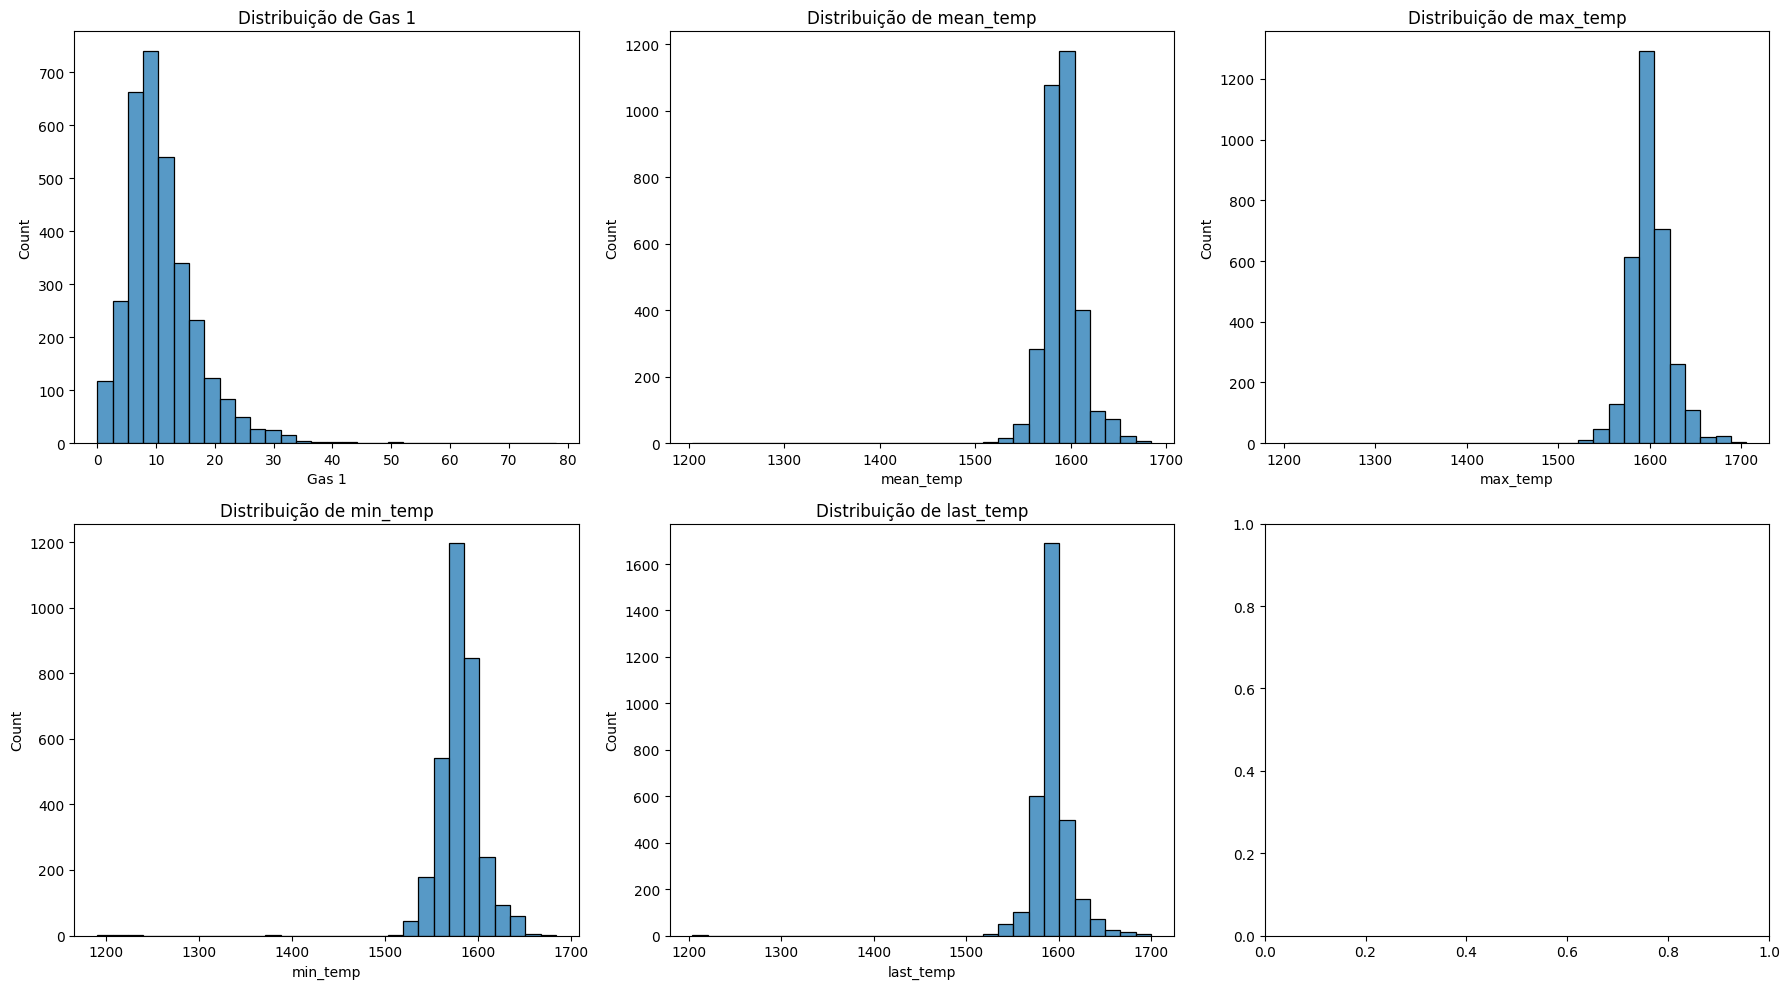

In [103]:
# Avaliando variáveis com boxplots e histogramas para os dados de temperatura:
main_vars = df_analysis.columns[43:48]

# Criando boxplots
fig, axes = plt.subplots(1, len(main_vars), figsize=(20, 5))
for i, var in enumerate(main_vars):
    sns.boxplot(y=df_analysis[var], ax=axes[i])
    axes[i].set_title(var)

# Criando histogramas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(main_vars):
    sns.histplot(data=df_analysis, x=var, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribuição de {var}')
    
plt.tight_layout()
plt.show()

Identificamos a necessidade de remoção de um outlier referente a Reactive Energy, que possivelmente foi um valor medido incorretamente que gerou um dado negativo. Após ajuste na seção de tratamento dos dados no início do notebook, podemos verificar que os dados apresentam comportamento predominantemente normal, porém alguns dados apresentam muitos outliers.

Ainda há os dados de BULK e WIRE, que não apenas possuem escalas muito diferentes entre si, como também diversos valores nulos. Para tentar uniformizar os dados, vamos trabalhar com o RobustScaler, que é mais indicado para valores com outliers.


<div class="alert alert-block alert-success">
<b>Comentário: </b> <a class="tocSkip"></a>

Bom trabalho de EDA!
</div>




- #### Separação dos conjuntos de treinamento e validação

Vamos adotar a temperatura final do processo como variável objetivo (target). As demais colunas serão nossos atributos (features).

Quando tentamos treinar o modelo, percebemos que os valores de NaT (valores em branco nos conjuntos de dados de data/hora) não são entendidos pelos modelos de previsão. Podemos extrair os dados (como dia/hora) para cada coluna, ou apenas remove-las do estudo. Considerando que equipamentos produtivos não são sazonais (sua eficiência não depende do período), para este primeiro teste iremos remover todas as colunas do tipo datetime da análise.

Valores NaN na variável Target também invalidam o treinamento do modelo, portanto removemos as linhas em que isto ocorreu.

In [104]:
# Removendo valores NaN da variável target:
df_analysis = df_analysis.dropna(subset=['last_temp'])

# Definindo variáveis target e features:
target = df_analysis['last_temp']
features = df_analysis.drop('last_temp', axis=1)

# Removendo valores .datetime
datetime_columns = features.select_dtypes(include=['datetime64']).columns.tolist()
features = features.drop(datetime_columns, axis=1)

In [105]:
# Separando o dataset em conjuntos de treinamento e validação:

features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.2,
    random_state=12345)

In [106]:
# Aplicando RobustScaler():
numeric_columns = features.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('key')

scaler = RobustScaler()

# Aplicando o scaler apenas nas colunas numéricas do conjunto de treino
features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()

# Fit e transform no conjunto de treino
features_train_scaled[numeric_columns] = scaler.fit_transform(features_train[numeric_columns])

# Apenas transform no conjunto de teste (usando os parâmetros do treino)
features_test_scaled[numeric_columns] = scaler.transform(features_test[numeric_columns])

/.venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/.venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Foram criadas as variaveis scaled, como `features_train_scaled`, mas não foram utilizadas posteriormente

- #### Treinamento do modelo e otimização de parâmetros

Nesta seção, iremos realizar o treinamento do modelo utilizando as bibliotecas CatBoost e LightGBM. Como modelo-base, onde possamos comparar se a eficácia do nosso modelo desenvolvido está de acordo, criaremos um modelo com a média do valor de 'last_temp'.

Modelos menos sofisticados como Regressão Linear ou Floresta Aleatória não aceitam valores NaN, que são abundantes em nosso conjunto de dados e, como tratamos de parâmetros de um processo físico-químico, substituição destes valores por suposições não são recomendadas.

O treinamento foi realizado tanto com os dados normalizados quanto com os dados brutos. Os testes indicaram que os valores normalizados não otimizaram o modelo, portanto removemos a parte do código que realizou estes testes.

In [107]:
%%time
# Criação de modelo com a média dos valores de 'last_temp':

predict_mean = [df_analysis['last_temp'].mean()] * len(target_test)
mse = mean_squared_error(target_test, predict_mean)
mae = mean_absolute_error(target_test, predict_mean)
print('Modelo-Base MAE =', mae)
print('Modelo-Base EQM =', mse)
print('Modelo-Base REQM =', mse ** 0.5)

Modelo-Base MAE = 12.430344396032263
Modelo-Base EQM = 331.8353926983886
Modelo-Base REQM = 18.216349598599294
CPU times: user 1.76 ms, sys: 0 ns, total: 1.76 ms
Wall time: 1.28 ms


In [108]:
%%time
# Treinando o modelo CatBoostRegressor + otimização de parâmetros:

for it in range(20, 201, 20):
    model_CatBoost = CatBoostRegressor(iterations=it, random_seed=12345)
    model_CatBoost.fit(features_train, target_train, verbose=50)
    
    predicted_valid = model_CatBoost.predict(features_test)
    mse = mean_squared_error(target_test, predicted_valid)
    mae = mean_absolute_error(target_test, predicted_valid)
    print('Valor para parâmetro Iterations: ', it)
    print('CatBoost MAE =', mae)
    print('CatBoost MSE =', mse)
    print('CatBoost RMSE =', mse ** 0.5)
    print('CatBoost R² =', model_CatBoost.score(features_test, target_test))
    print()

Learning rate set to 0.5
0:	learn: 14.4122821	total: 1.73ms	remaining: 32.8ms
19:	learn: 5.1319794	total: 74.7ms	remaining: 0us
Valor para parâmetro Iterations:  20
CatBoost MAE = 4.354076176057634
CatBoost MSE = 33.798400390222895
CatBoost RMSE = 5.813639169248716
CatBoost R² = 0.8977132027276685

Learning rate set to 0.5
0:	learn: 14.4122821	total: 1.74ms	remaining: 67.8ms
39:	learn: 3.4337252	total: 126ms	remaining: 0us
Valor para parâmetro Iterations:  40
CatBoost MAE = 3.6520093696317923
CatBoost MSE = 23.67917427820162
CatBoost RMSE = 4.866125181106793
CatBoost R² = 0.928337824541801

Learning rate set to 0.468129
0:	learn: 14.7301109	total: 1.67ms	remaining: 98.4ms
50:	learn: 3.1522593	total: 198ms	remaining: 34.9ms
59:	learn: 2.8866860	total: 282ms	remaining: 0us
Valor para parâmetro Iterations:  60
CatBoost MAE = 3.321922357953956
CatBoost MSE = 21.08807751682067
CatBoost RMSE = 4.59217568444639
CatBoost R² = 0.9361794675214798

Learning rate set to 0.370502
0:	learn: 15.76251

In [109]:
%%time
# Treinamento do modelo LGBM + otimização de parâmetros
train_data = lgb.Dataset(features_train, label=target_train)
valid_data = lgb.Dataset(features_test, label=target_test, reference=train_data)

for leaves in range(10, 51, 20):
    for rounds in range(20, 221, 40):
        
        param = {
            'objective': 'regression',  
            'metric': 'rmse',           
            'num_leaves': leaves,
            'learning_rate': 0.1,
            'random_seed': 12345,
            'feature_fraction': 0.9}
        
        num_round = rounds
        model_lgb = lgb.train(
            param, 
            train_data, 
            num_round, 
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(10)]
        )

# Predições e análise dos dados
        predicted_valid_lgb = model_lgb.predict(features_test)
        mae = mean_absolute_error(target_test, predicted_valid_lgb)
        mse = mean_squared_error(target_test, predicted_valid_lgb)
        
        print('Parâmetro num_leaves utilizado: ', leaves)
        print('Parâmetro num_round utilizado: ', rounds)
        print('LightGBM MAE =', mae)
        print('LightGBM EQM =', mse)
        print('LightGBM REQM =', mse ** 0.5)
        print('LightGBM R² =', r2_score(target_test, predicted_valid_lgb))
        print()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5734
[LightGBM] [Info] Number of data points in the train set: 2572, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1593.631415
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 5.85193
Parâmetro num_leaves utilizado:  10
Parâmetro num_round utilizado:  20
LightGBM MAE = 4.048911957470912
LightGBM EQM = 34.24503303282248
LightGBM REQM = 5.851925583329172
LightGBM R² = 0.8963615227060897

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overh

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Otimização dos modelos realizada corretamente. 

Dica: O uso de GridSearch ou RandomSearch pode ter implementacões mais eficientes ao invés da otimização manual

Mediante otimização de parâmetros para ambos os modelos, executamos o treinamento apenas para os melhores encontrados, assim podemos avaliar o custo computacional de cada treinamento:

In [110]:
%%time
# Treinando modelo catboost utilizando iterations = 200:

model_CatBoost = CatBoostRegressor(iterations=200, random_seed=12345)
model_CatBoost.fit(features_train, target_train, verbose=200)

predicted_valid = model_CatBoost.predict(features_test)
mse = mean_squared_error(target_test, predicted_valid)
mae = mean_absolute_error(target_test, predicted_valid)
print('Valor para parâmetro Iterations: ', it)
print('CatBoost MAE =', mae)
print('CatBoost MSE =', mse)
print('CatBoost RMSE =', mse ** 0.5)
print('CatBoost R² =', model_CatBoost.score(features_test, target_test))

Learning rate set to 0.1759
0:	learn: 18.0330512	total: 1.74ms	remaining: 347ms
199:	learn: 2.3359349	total: 955ms	remaining: 0us
Valor para parâmetro Iterations:  200
CatBoost MAE = 2.8570539260937062
CatBoost MSE = 15.636972866451053
CatBoost RMSE = 3.954361246326776
CatBoost R² = 0.9526765806938511
CPU times: user 1.92 s, sys: 176 ms, total: 2.09 s
Wall time: 1.06 s


In [126]:
# Analisando a importância de cada coluna para a variável objetivo:

feature_importance = model_CatBoost.get_feature_importance()
feature_names = features_train.columns

# Criando um DataFrame para visualizar melhor
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

       feature  importance
29   mean_temp   39.334091
30    max_temp   35.054908
31    min_temp    5.399122
12  sum_energy    2.910372
32    Wire 1_x    2.864860
10  max_energy    2.062585
8      sum_dur    2.046368
0          key    1.973382
28       Gas 1    0.977313
6      max_dur    0.956909


In [115]:
%%time
# Treinando modelo LGBM utilizando iterations = 200:

train_data = lgb.Dataset(features_train, label=target_train)
valid_data = lgb.Dataset(features_test, label=target_test, reference=train_data)

param = {
    'objective': 'regression',  
    'metric': 'rmse',           
    'num_leaves': 30,
    'learning_rate': 0.1,
    'random_seed': 12345,
    'feature_fraction': 0.9}
        
model_lgb = lgb.train(
    param, 
    train_data, 
    100, 
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(10)]
        )

predicted_valid_lgb = model_lgb.predict(features_test)
mae = mean_absolute_error(target_test, predicted_valid_lgb)
mse = mean_squared_error(target_test, predicted_valid_lgb)

print('Parâmetro num_leaves utilizado: ', leaves)
print('Parâmetro num_round utilizado: ', rounds)
print('LightGBM MAE =', mae)
print('LightGBM EQM =', mse)
print('LightGBM REQM =', mse ** 0.5)
print('LightGBM R² =', r2_score(target_test, predicted_valid_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5734
[LightGBM] [Info] Number of data points in the train set: 2572, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1593.631415
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's rmse: 3.98856
Parâmetro num_leaves utilizado:  50
Parâmetro num_round utilizado:  220
LightGBM MAE = 2.6653740956134486
LightGBM EQM = 15.90858102525285
LightGBM REQM = 3.9885562582534613
LightGBM R² = 0.9518545912400275
CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 544 ms


In [127]:
# Analisando a importância de cada coluna para a variável objetivo:

feature_importance = model_lgb.feature_importance(importance_type='gain')
feature_names = features_train.columns

# Criando um DataFrame para visualizar
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

          feature    importance
29      mean_temp  2.837558e+06
30       max_temp  1.636958e+06
31       min_temp  2.137478e+05
12     sum_energy  1.261136e+05
8         sum_dur  5.343534e+04
32       Wire 1_x  3.353829e+04
28          Gas 1  3.121213e+04
0             key  2.354369e+04
26      Bulk 14_x  1.054201e+04
1   max_act_power  1.036680e+04


In [122]:
data_arc.columns

Index(['key', 'Arc heating start', 'Arc heating end', 'Active power',
       'Reactive power'],
      dtype='object')

In [124]:
df_data_arc['energy_total'].mean()

154.13170931922497

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Bom trabalho no uso de feature_importance! Caso queira se aprofundar nas explicabilidade de modelos, procure por Shap Values e lime. 

Saiba mais em: 

- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

- https://github.com/marcotcr/lime 

# Conclusão

No presente projeto, foram desenvolvidos dois modelos de aprendizado de máquina com base em algoritmos de gradiente descendente para previsão de dados de temperatura final do processo de produção de aço em lingotes. Ao longo da atividade foi possível extrair algumas conclusões:

- **Particularidade dos dados**

Para conseguirmos modelar a solução, foi necessário executar uma etapa de tratamento de dados intensa, onde não apenas ajustamos os dados existentes como também foi necessário criar outros. Conhecimento físico-químico também auxiliou no desenvolvimento, pois conceitos de potência foram aplicados. A grande quantidade de valores nulos e a presença de outliers não impactou a qualidade do modelo proposto devido a robstez das bibliotecas CatBoost e LightGBM e seus métodos empregados.

- **Resultados obtidos**

Os modelos treinados foram capazes de atingir erro absoluto médio de apenas 2.7 °C. Dada a média dos valores de temperatura igual a 1593.9 °C, isso representa um desvio de 1,6% em média. O R² de ambos os modelos chegaram a valores também muito interessantes, acima de 0.95, o que é considerado excelente para previsões em escala industrial de processos físico-químicos. Desta forma, acredita-se que o modelo pode prever com precisão valores de temperatura a partir de dados previamente fornecidos. Vale ressaltar também que as bibliotecas utilizadas para modelagem são de alta eficiência e consideradas modernas, portanto não requerem um custo computacional muito alto.

Visto que as unidades não foram fornecidas, ganhos energéticos não podem ser mensurados. Entretanto, um caminho para otimização do processo produtivo pode ser via aplicação de séries de valores para cada variável, entendendo assim seu impacto no valor de temperatura final. Ficou claro pela análise de importância que as características principais são as temperaturas anteriores, o que faz sentido pois a última temperatura nunca irá se distanciar demais das outras. 

- **Conclusões**

Desta forma, pode-se concluir que o projeto entregou o resultado desejado, baseado em modelos precisos de previsão dos mais modernos atualmente, que puderam entregar resultados significativos para o sistema em estudo.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Boa conclusão!